<a href="https://colab.research.google.com/github/MehrdadJalali-AI/socialNetworkOptimization/blob/main/SOCAIL_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         Function  Best Fitness  Worst Fitness  Mean Fitness       Std Dev  \
0          Sphere    542.187513    1630.784291    925.805497    345.133093   
1   Schwefel 2.22     11.368644      18.998070     14.977846      2.341929   
2    Schwefel 1.2   1021.891755    3296.736114   2190.621518    656.994911   
3   Schwefel 2.21     10.813255      21.641855     16.221183      3.444354   
4      Rosenbrock  13547.865888  166375.271115  88142.220627  53292.460611   
5            Step    394.000000    2051.000000   1268.100000    534.697008   
6         Quartic      0.107510       0.445402      0.203442      0.094264   
7   Schwefel 2.26   6571.278908    9318.464649   7572.927812    765.254097   
8       Rastrigin     89.090638     177.212878    122.706585     25.930444   
9          Ackley      8.511022      12.197427     10.148457      1.261918   
10       Griewank      6.705468      12.899683      9.873806      1.927834   
11      Penalized      7.557890      24.821154     13.748717    

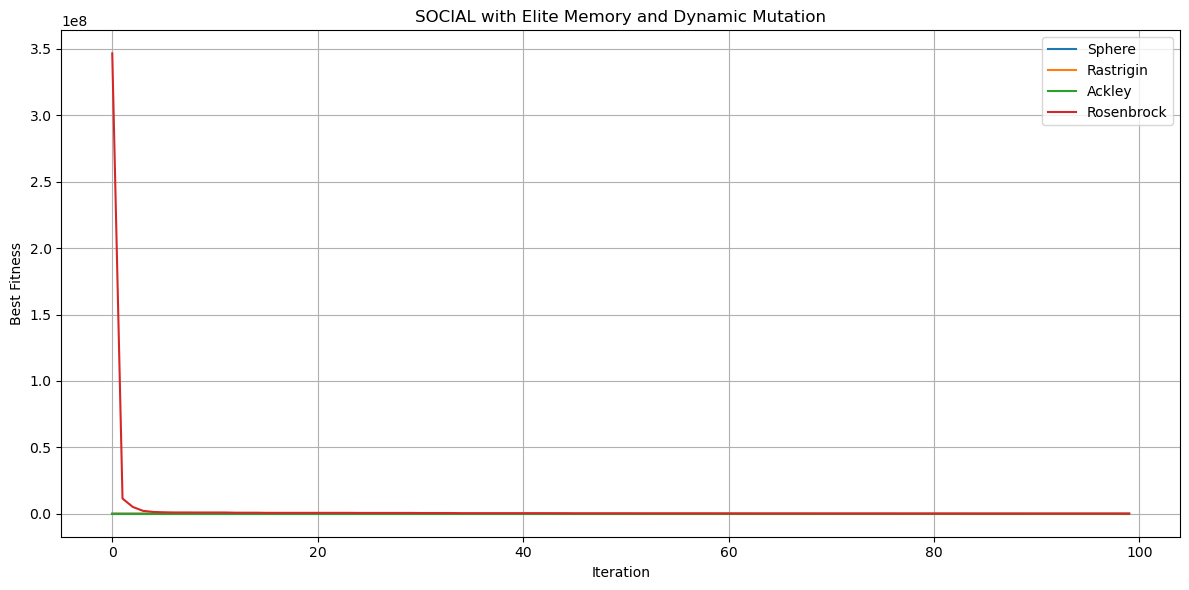

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Benchmark Functions ---
def sphere(x): return sum(xi**2 for xi in x)
def schwefel_2_22(x): return sum(abs(xi) for xi in x) + np.prod([abs(xi) for xi in x])
def schwefel_1_2(x): return sum([sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return max(abs(xi) for xi in x)
def rosenbrock(x): return sum([100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1)])
def step(x): return sum(np.floor(xi + 0.5)**2 for xi in x)
def quartic(x): return sum((i+1) * xi**4 for i, xi in enumerate(x)) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - sum(xi * np.sin(np.sqrt(abs(xi))) for xi in x)
def rastrigin(x): return 10 * len(x) + sum(xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x)
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(sum(xi**2 for xi in x) / d)) - np.exp(sum(np.cos(c * xi) for xi in x) / d) + a + np.exp(1)
def griewank(x):
    sum_part = sum(xi**2 / 4000 for xi in x)
    prod_part = np.prod([np.cos(xi / np.sqrt(i + 1)) for i, xi in enumerate(x)])
    return sum_part - prod_part + 1
def penalized(x):
    n = len(x)
    y = [1 + (xi + 1) / 4 for xi in x]
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(n-1)])
    term3 = (y[-1] - 1)**2
    u = sum([100 * (xi - 10)**4 if xi > 10 else (-xi - 10)**2 if xi < -10 else 0 for xi in x])
    return (np.pi / n) * (term1 + term2 + term3) + u
def penalized2(x):
    n = len(x)
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(n-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = sum([100 * (xi - 10)**4 if xi > 10 else (-xi - 10)**2 if xi < -10 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u
def alpine(x): return sum(abs(xi * np.sin(xi) + 0.1 * xi) for xi in x)

benchmark_functions = {
    "Sphere": sphere, "Schwefel 2.22": schwefel_2_22, "Schwefel 1.2": schwefel_1_2,
    "Schwefel 2.21": schwefel_2_21, "Rosenbrock": rosenbrock, "Step": step,
    "Quartic": quartic, "Schwefel 2.26": schwefel_2_26, "Rastrigin": rastrigin,
    "Ackley": ackley, "Griewank": griewank, "Penalized": penalized,
    "Penalized2": penalized2, "Alpine": alpine
}

function_details = {
    "Sphere": (30, [-100, 100]), "Schwefel 2.22": (30, [-10, 10]), "Schwefel 1.2": (30, [-100, 100]),
    "Schwefel 2.21": (30, [-100, 100]), "Rosenbrock": (30, [-30, 30]), "Step": (30, [-100, 100]),
    "Quartic": (30, [-1.28, 1.28]), "Schwefel 2.26": (30, [-500, 500]), "Rastrigin": (30, [-5.12, 5.12]),
    "Ackley": (30, [-32, 32]), "Griewank": (30, [-600, 600]), "Penalized": (30, [-50, 50]),
    "Penalized2": (30, [-50, 50]), "Alpine": (30, [-10, 10])
}

# --- Refined SOCIAL Core Functions ---
def initialize_population_social(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.3)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

def evaluate_fitness_social(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)
    return len(G.nodes)

def diffuse_information(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, max_iterations):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    max_fitness = max(fitness_values) + 1e-6
    influence = 1 - (fitness_values / max_fitness)

    # Dynamic parameters
    alpha_t = alpha * (1 - iteration / max_iterations)
    beta_t = beta * (1 - iteration / max_iterations)
    gamma_t = gamma * (iteration / max_iterations)
    delta_t = delta * (iteration / max_iterations)  # Elite influence increases over time

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[n] for n in neighbors]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        # Combine self, neighbor, gbest, and elite contributions
        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    # Dynamic mutation: strength decreases over iterations
    median_fitness = np.median(fitness_values)
    mutation_rate = 0.1  # Fixed probability
    mutation_strength = 0.1 * (1 - iteration / max_iterations) + 0.01  # Decays from 10% to 1%
    mutation_range = mutation_strength * (bounds[1] - bounds[0])
    for node in G.nodes:
        if G.nodes[node]['fitness'] > median_fitness and np.random.random() < mutation_rate:
            perturbation = np.random.uniform(-mutation_range, mutation_range, len(new_positions[node]))
            new_positions[node] = np.clip(new_positions[node] + perturbation, bounds[0], bounds[1])

    for node, pos in new_positions.items():
        G.nodes[node]['position'] = pos

def social_optimize(func, dim, bounds, num_nodes=30, iterations=100, alpha=0.4, beta=0.4, gamma=0.2, delta=0.1):
    G = initialize_population_social(num_nodes, dim, bounds)
    fitness_history = []
    total_evaluations = 0

    # Initialize global best and elite
    evaluate_fitness_social(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()  # Elite starts as initial gbest
    elite_fitness = gbest_fitness

    for iteration in range(iterations):
        evaluations = evaluate_fitness_social(G, func)
        total_evaluations += evaluations

        # Update global best and elite
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
        min_fitness_idx = np.argmin(fitness_values)
        if fitness_values[min_fitness_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_fitness_idx]['position'].copy()
            gbest_fitness = fitness_values[min_fitness_idx]
        if gbest_fitness < elite_fitness:  # Update elite if gbest improves
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        diffuse_information(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, iterations)
        fitness_history.append(gbest_fitness)

    best_solution = elite_pos  # Return elite as final best
    final_positions = np.array([G.nodes[n]['position'] for n in G.nodes])
    return fitness_history, best_solution, total_evaluations, final_positions

# --- Run on All Functions ---
num_runs = 10
max_iterations = 100
num_nodes = 30

results = []

for name, func in benchmark_functions.items():
    dim, bounds = function_details[name]
    all_histories = []
    all_final_pos = []
    best_fits = []

    for _ in range(num_runs):
        hist, _, _, final_positions = social_optimize(func, dim, bounds, num_nodes, max_iterations)
        all_histories.append(hist)
        best_fits.append(min(hist))
        all_final_pos.append(final_positions)

    mean_fit = np.mean(best_fits)
    std_fit = np.std(best_fits)
    diversity = np.mean([np.var(pos) for pos in all_final_pos])
    robustness = np.var(best_fits)
    convergence_speed = (num_nodes * max_iterations) / max_iterations  # Equal to num_nodes

    results.append({
        "Function": name,
        "Best Fitness": np.min(best_fits),
        "Worst Fitness": np.max(best_fits),
        "Mean Fitness": mean_fit,
        "Std Dev": std_fit,
        "Robustness": robustness,
        "Diversity": diversity,
        "Convergence Speed": convergence_speed
    })

# --- Save CSV ---
df_results = pd.DataFrame(results)
df_results.to_csv("SOCIAL_Results_Elite_Dynamic.csv", index=False)
print(df_results)

# --- Plot convergence for selected functions ---
selected = ["Sphere", "Rastrigin", "Ackley", "Rosenbrock"]
plt.figure(figsize=(12, 6))
for i, name in enumerate(selected):
    dim, bounds = function_details[name]
    hist, _, _, _ = social_optimize(benchmark_functions[name], dim, bounds)
    plt.plot(hist, label=name)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.title("SOCIAL with Elite Memory and Dynamic Mutation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()